In [1]:
%reload_ext autoreload
%autoreload 2

### Stream Based Active Learner with Uncertainity Sampling Query Strategy

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=2)
transformed_iris = pca.fit_transform(X=X_raw)

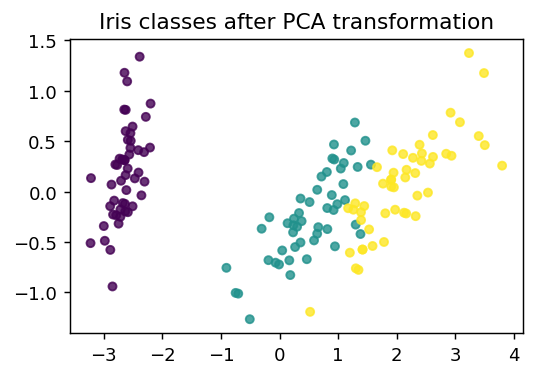

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(4.5, 3), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=20, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [12]:
import numpy as np
np.random.seed(41)
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size = 3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [13]:
y_train

array([2, 1, 1])

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from learner import ActiveLearner

# Specify model along with it's active learning model.
knn = RandomForestClassifier(n_estimators=5)
learner = ActiveLearner(models = [knn], strategy = "uncertainity", uncertainity_measure = "h")

In [15]:
learner.teach(X_train, y_train)

In [16]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2])

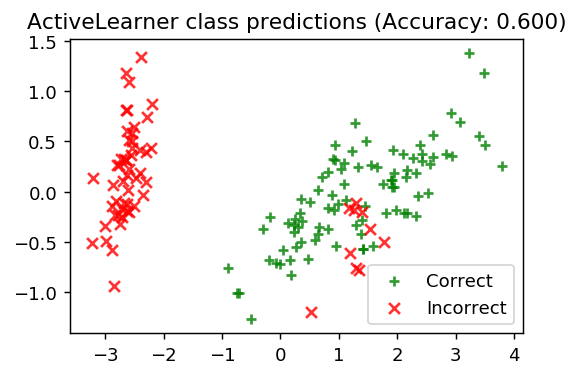

In [17]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [19]:
N_QUERIES = X_pool.shape[0]
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
while performance_history[-1] < 0.95:
    index = 0
    while index < X_pool.shape[0]:
        do_query_sample = learner.query(X_pool[index][None, :])

        # Teach our ActiveLearner model the record it has requested.
        if do_query_sample:
            X, y = X_pool[index][None, :], y_pool[index].reshape(1)
            learner.teach(X=X, y=y)
            
            # Remove the queried instance from the unlabeled pool.
            X_pool, y_pool = np.delete(X_pool, index, axis=0), np.delete(y_pool, index)
            index -= 1
            
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(X_raw, y_raw)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
        index += 1

Accuracy after query 50: 0.5133
Accuracy after query 68: 0.4267
Accuracy after query 96: 0.4867
Accuracy after query 97: 0.5467
Accuracy after query 97: 0.6333
Accuracy after query 99: 0.3533
Accuracy after query 101: 0.6067
Accuracy after query 101: 0.5800
Accuracy after query 101: 0.5533
Accuracy after query 102: 0.5533
Accuracy after query 102: 0.6267
Accuracy after query 106: 0.6067
Accuracy after query 107: 0.6333
Accuracy after query 108: 0.6333
Accuracy after query 108: 0.5333
Accuracy after query 108: 0.6000
Accuracy after query 108: 0.6067
Accuracy after query 115: 0.6333
Accuracy after query 118: 0.4600
Accuracy after query 0: 0.8000
Accuracy after query 0: 0.8933
Accuracy after query 0: 0.8533
Accuracy after query 0: 0.9400
Accuracy after query 1: 0.9067
Accuracy after query 5: 0.8733
Accuracy after query 8: 0.8400
Accuracy after query 8: 0.8667
Accuracy after query 42: 0.9200
Accuracy after query 43: 0.9533
Accuracy after query 43: 0.9333
Accuracy after query 43: 0.9667
Acc

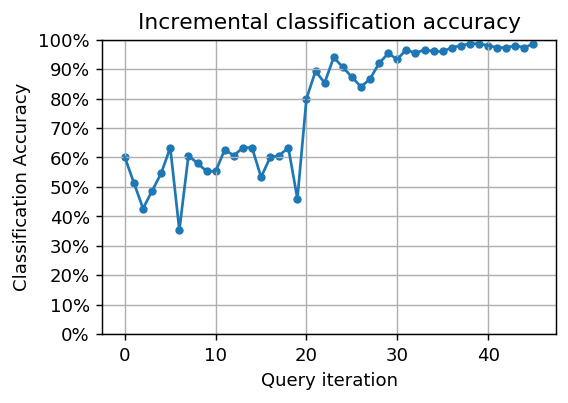

In [20]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

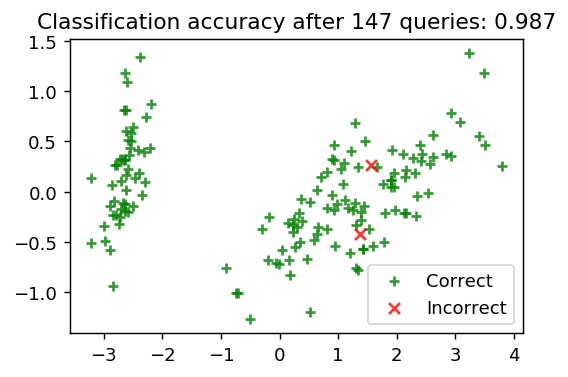

In [21]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()